# 土炮自製撲克牌圖像資料集 (Home-made Poker cards Dataset)

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTRNL-d_M_vqDFx7n8eTwq5dBk0ulDVeDQFSPDh4PkSe3M4IJPK)

## 資料集說明

這個範例主要是希望透過一個簡單的示範來帶領大家使用一些簡單的工具與手法來產生一個可以用來作圖像辨識練習的圖像資料集。

撲克牌圖像資料集主要由一張包含了52張撲克牌的大圖像來進行切割以及透過簡單的影像處理所產生出來。它包含52張撲克牌的圖像。
主要的步驟如下:
1. 下載原始撲克牌的大圖像, 例如: http://www.eypo-bet.com/wp-content/uploads/2015/12/poker.cards_.png
2. 使用Windows內附的"小畫家"打開撲克牌的大圖像
3. 使用Windows內附的"裁剪工作(snipping tool)"將每張牌一張一張的裁剪下來並存成png的格式
4. 由於撲克牌有四種花樣與13個數字,存檔時以`{花樣}{數字}.png`的檔名進行儲存, 比如`c01.png` (黑桃1)
5. 使用"GIMP"修圖軟體去除四週邊框
6. 使用"Excel"編寫一個資料表來標註每一個圖像與標籤的關聯資訊:
    * 花樣 (card_type): club, diamond, heart與spear
    * 牌面數字(card_num): 1 ~ 13
    * 標籤(card_label): club1~club13, diamond1~diamond13, heart1~heart13 與 spear1~spear13

## 資料準備
1. 手動執行前述的資料裁剪工作或是從[Google-drive](https://drive.google.com/file/d/1M4lHt-ASGymJf-dBwRz7VmZ8sqMf6MKx/view?usp=sharing)下載預先裁剪的結果的壓縮檔"cards.zip"。
2. 在這個Jupyter Notebook所在的目錄下產生一個新的子目錄"data"。
3. 解壓縮圖像資料檔到"data"的目錄裡頭。
4. 在"data"的目錄中, 產生一個子目錄"train"用來存放要用來訓練用的圖像檔。
  
最後你的目錄結構看起來像這樣:
```
xxxx.ipynb
cards_data.xlsx
data/
├── origin_imgs/
│   ├── c01.PNG
│   ├── c02.PNG
│   ├── ..
│   └── s13.PNG
└── train/

```

## 撲克牌圖像辨識 (Poker cards Recognition)

In [1]:
# 匯入相關所需的模組
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pathlib import PurePath
import cv2

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 置放資料的路徑
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 置放原始圖像檔案的路徑
ORIGIN_IMG_PATH = os.path.join(DATA_PATH, "origin_imgs")

# 置放要用來訓練用圖像檔案的路徑
TRAIN_IMG_PATH = os.path.join(DATA_PATH, "train")

# 訓練用的圖像大小與色階
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHANNEL = 1

Using TensorFlow backend.


## 資料預處理 (Data Preprocessing)
預處理圖片的第一步將數據資料轉換型別為`float32`來節省一些記憶的用量並對它們進行歸一化（除以255）。

然後使用one-hot編碼來將標籤(label)轉換為向量(vector)：

### 進行圖像色階轉換及大小的修改

為了能夠節省要訓練的參數與運算量, 我們要將圖像由彩色轉為灰階圖像, 並且將圖像的大小轉換成28x28。

In [2]:
# 取得原始圖像的檔案路徑
all_img_paths = glob.glob(os.path.join(ORIGIN_IMG_PATH, "*.PNG"))

# 進行圖像色階轉換及大小的修改
for img_path in all_img_paths:
    filename = (PurePath(img_path).stem) # 取得原圖像檔案名稱, 例如.c01
    new_filename = filename + ".png" # 更換附檔名    
    card_img_grey = cv2.imread(img_path, 0) # 使用OpenCV以灰階讀入
    card_img = cv2.resize(card_img_grey, (IMG_HEIGHT, IMG_WIDTH)) # 轉換大小  
    cv2.imwrite(os.path.join(TRAIN_IMG_PATH, new_filename), card_img) # 寫出

### 轉換前與轉換後的圖像資料
轉換前的圖像:

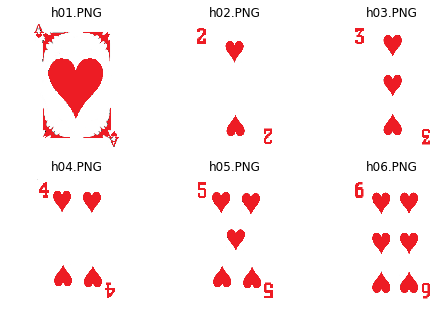

In [3]:
plt.figure(figsize=(8,8)) # 設定每個圖像顯示的大小

# 產生一個3x2網格的組合圖像
for i in range(0, 6):
    img_file = 'h0'+str(i+1)+'.PNG'
    img = cv2.imread(os.path.join(ORIGIN_IMG_PATH, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(330+1+i) # (331) -> 第一個子圖像, (332) -> 第二個子圖像
    plt.title(img_file)  # 秀出原圖像的檔名
    plt.axis('off')      #不顯示坐標
    plt.imshow(img)      # 圖像顯示
    
# 展現出圖像
plt.show()

轉換後的圖像:

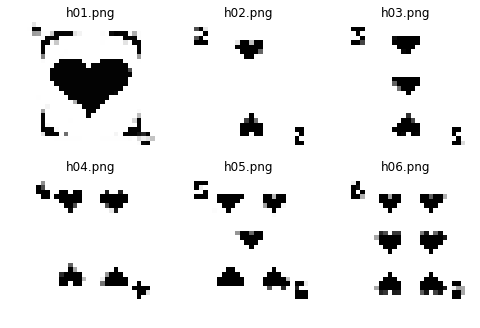

In [4]:
plt.figure(figsize=(8,8)) # 設定每個圖像顯示的大小

# 產生一個3x2網格的組合圖像
for i in range(0, 6):
    img_file = 'h0'+str(i+1)+'.png'
    img = cv2.imread(os.path.join(TRAIN_IMG_PATH, img_file),0)
    
    plt.subplot(330+1+i) # (331) -> 第一個子圖像, (332) -> 第二個子圖像
    plt.title(img_file)  # 秀出原圖像的檔名
    plt.axis('off')      #不顯示坐標
    plt.imshow(img, cmap=plt.get_cmap('gray'))      # 圖像顯示
    
# 展現出圖像
plt.show()

取得要進行訓練的X與標籤y

In [5]:
num_classes = 52 # 撲克牌的標籤總共有52類
img_rows, img_cols, img_channels = IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL # 圖像是 49像素 x 33像素 (灰色階: 1)
input_shape = (img_rows, img_cols, img_channels) # (圖像的height, 圖像的width, 圖像的顏色通道數channel)

# 載入標籤資料檔
cards_data = pd.read_excel(os.path.join(DATA_PATH, 'cards_data.xlsx'))

# 取得"card_label"的欄位資料
cards_label = cards_data['card_label']
 
# 產生相關的查找的字典物件
idx_to_label = {k:v for k, v in cards_label.iteritems()}
label_to_idx = {v:k for k, v in cards_label.iteritems()}

# 取得所有圖像的標籤值
y = np.array(cards_label.index.values)

# 進行標籤的one-hot編碼
y_train = to_categorical(y, num_classes)
y_test = y_train.copy()

# 將每個圖像從檔案中讀取進來
imgs = []
all_img_paths = glob.glob(os.path.join(TRAIN_IMG_PATH, "*.png"))

#進行圖像每個像素值的型別轉換與歸一化處理
for img_path in all_img_paths:
    img = cv2.imread(img_path,0) # 以灰階讀入
    img = img.astype('float32')/255.
    imgs.append(img)
    
# 取得要進行訓練用的灰階圖像
X = np.array(imgs)    

# 將圖像數據集的維度進行改變 
# 改變前: [樣本數, 圖像寬, 圖像高] -> 改變後: [樣本數, 圖像寬, 圖像高, 圖像頻道數]
X_train = X.reshape(X.shape[0], 28, 28, 1)
X_test = X_train.copy()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (52, 28, 28, 1)
y_train: (52, 52)


## 網絡模型 (Model)

現在我們來定義我們的模型架構。我們將使用具有6個卷積層的前饋網絡，然後是完全連接的隱藏層。
我們也將在兩者之間使用Dropout層來防止網絡"過擬合(overfitting)"。

In [6]:
# 產生一個Keras序貫模型
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2
                                     )))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model;   

model = cnn_model() # 初始化一個模型
model.summary() # 秀出模型架構

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

在訓練模型之前，我們需要將模型配置為學習算法並進行編譯。我們需要指定:
* `loss`: 損失函數，我們要優化。我們不能使用`MSE`，因為它是不連續的數值。因此，我們使用：`categorical_crossentropy`
* `optimizer`: 我們使用標準隨機梯度下降(Stochastic gradient descent)與涅斯捷羅夫動量(Nesterov momentum)
* `metric`: 由於我們正在處理一個分類問題，我們用度量是`accuracy`。

In [7]:
# 讓我們先配置一個常用的組合來作為後續優化的基準點
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

## 圖像增強 (Data Augmentation)

因為我們只有52張圖像, 因此利用現有的圖像來生成新的訓練圖像，這將是一個很好的方式來增加訓練數據集的大小。

讓我們直接使用keras的內置功能來完成圖像增強 (Data Augmentation)。

In [8]:
datagen_train = ImageDataGenerator(rotation_range=3.)
datagen_train.fit(X_train)

## 訓練 (Training)

現在，我們的模型已經準備好了。在訓練期間，我們的模型將進行迭代批量訓練，每個次的訓練資料的大小為batch_size。對於每批次，模型將會計算出梯度(gradient)，並自動更新網絡的權重。對所有訓練集的一次迭代被稱為一次的循環(epoch)。訓練通常會一直進行到損失收斂於一個常數。

In [9]:
batch_size = 100
steps_per_epoch = 50000
training_epochs = 700

# 透過data generator來產生訓練資料, 由於資料是可持續產生, 我們可以透過設定'steps_per_epoch'的數量來讓模型可以有更多的訓練批次
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch= steps_per_epoch,
                            epochs=training_epochs)

Epoch 1/700
    1/50000 [..............................] - ETA: 5:47:29 - loss: 3.9392 - acc: 0.0577Epoch 6/700
    .....
    .....
    .....
    1/50000 [..............................] - ETA: 5:58:19 - loss: 0.0055 - acc: 1.0000

### 訓練過程的可視化

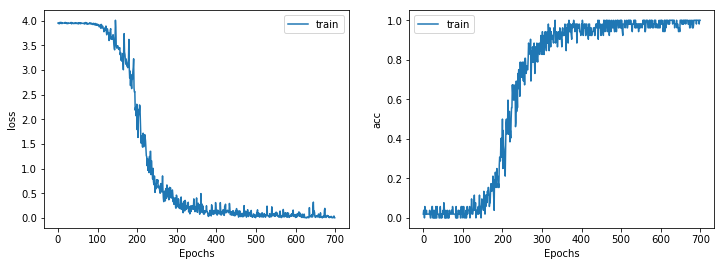

In [10]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics):
    plt.plot(history.history.get(train_metrics))
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss')

plt.subplot(1,2,2)
plot_train_history(history, 'acc')

plt.show()

## 驗證評估 (Evaluation)

In [11]:
score = model.evaluate(X_train, y_train, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

52/52 [==============================] - 0s 3ms/step
Test loss: 0.000443235971873
Test accuracy: 1.0


在這個範例中, 由於圖像資料太少所以並沒有特別在驗證資料集去進行驗證。但是從訓練資料集的檢查來看,這個卷積網路模型的確可以有效地識別每一張撲克牌圖像。

### 每一張撲克牌的預測
我們再來看每一張圖像的驗證結果:

In [12]:
# 打散圖像集的順序
randomize = np.arange(len(X_test))
np.random.shuffle(randomize)
X_test_randomize = X_test[randomize]
y_test_randomize = y_test[randomize]

In [13]:
# 計算打散後的圖像集驗證
score = model.evaluate(X_test_randomize, y_test_randomize, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

52/52 [==============================] - 0s 3ms/step
Test loss: 0.000443235991182
Test accuracy: 1.0


In [14]:
# 進行每一張牌的圖像辨識預測
print("\t[Info] Making prediction of X_test_randomize")  
prediction = model.predict_classes(X_test_randomize)  # Making prediction and save result to prediction  

print()  
print("\t[Info] Show 52 prediction result (From 0):")  
print("%s\n" % (prediction[:52]))

	[Info] Making prediction of X_test_randomize

	[Info] Show 52 prediction result (From 0):
[ 9  6  7 30  8 21  3 14 31 26 35 12 34 17 50 15 37 44 23 43 51  2  5 49 24
 20 42 10 25 46 33 38 29  4 13 11 27 19 45 32 48 47  0 28  1 22 16 39 40 18
 36 41]



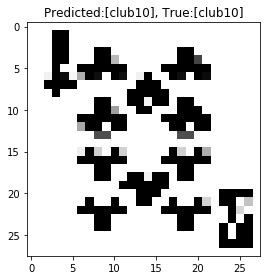

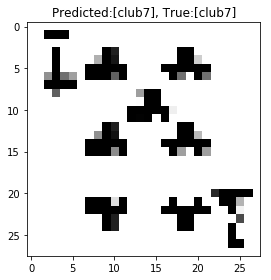

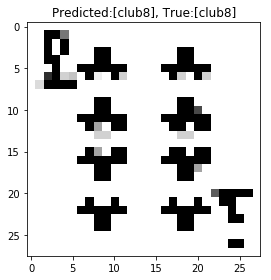

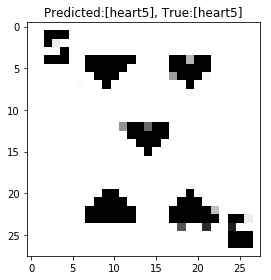

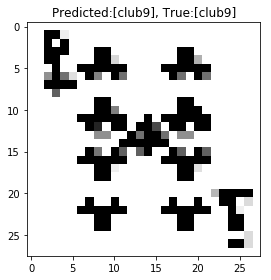

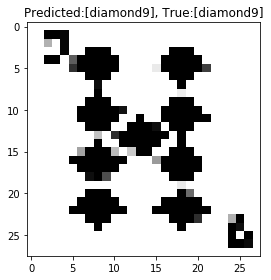

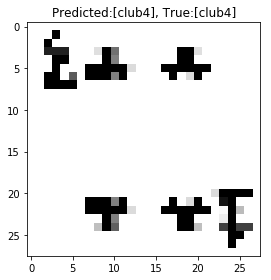

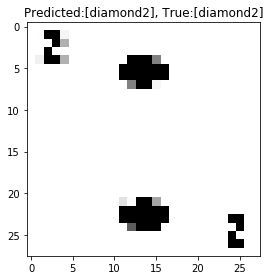

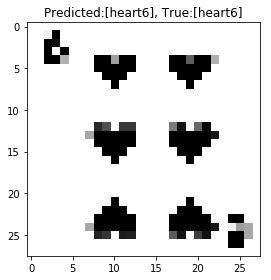

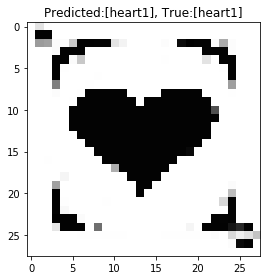

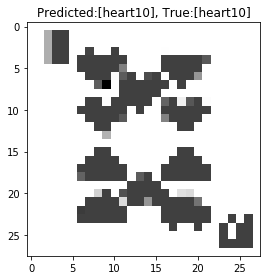

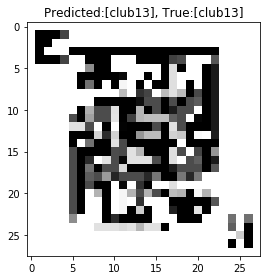

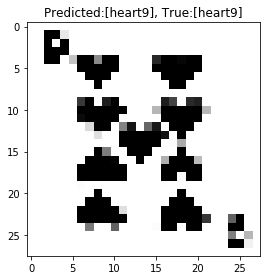

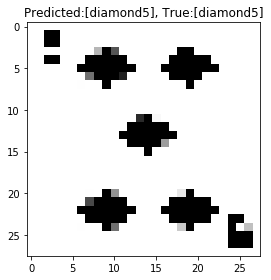

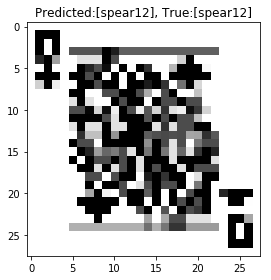

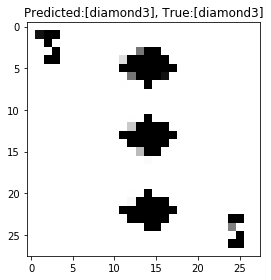

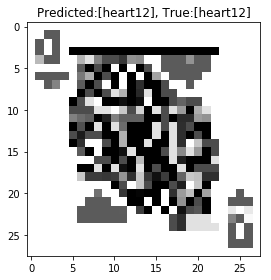

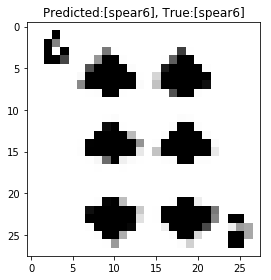

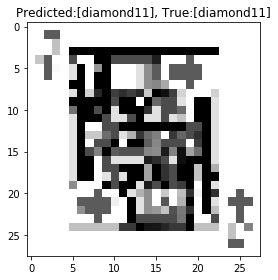

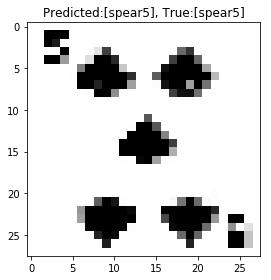

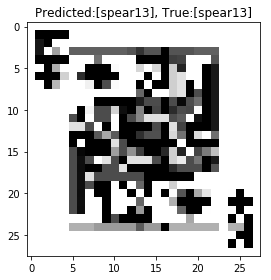

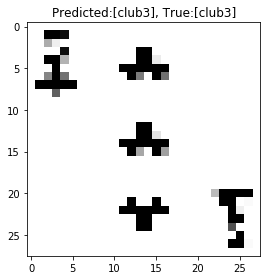

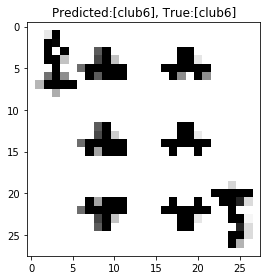

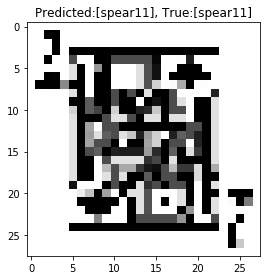

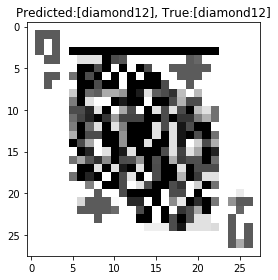

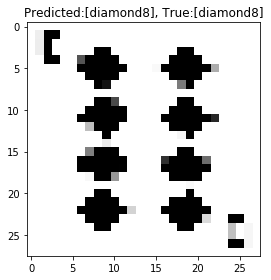

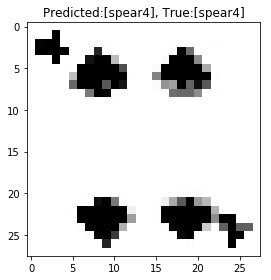

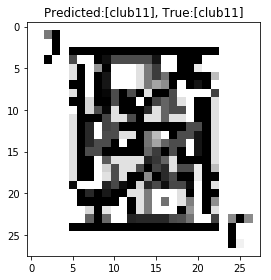

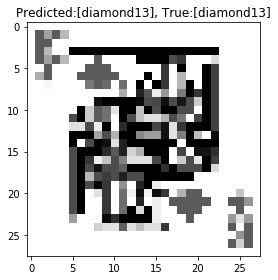

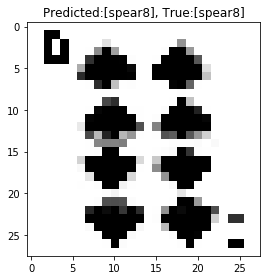

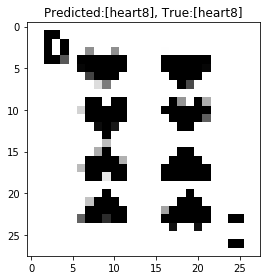

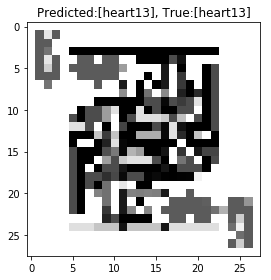

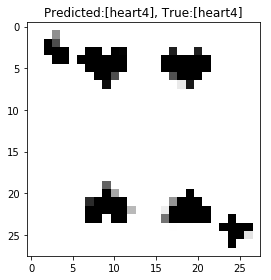

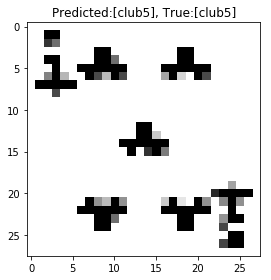

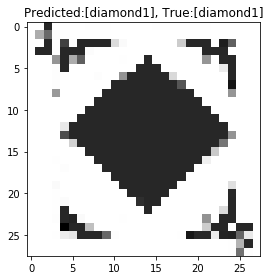

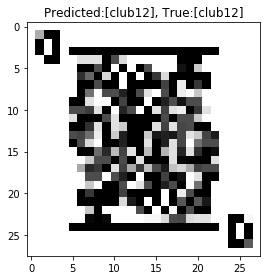

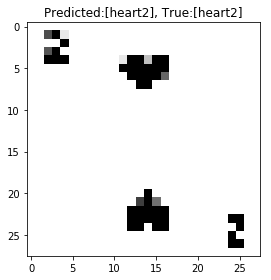

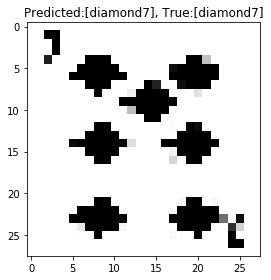

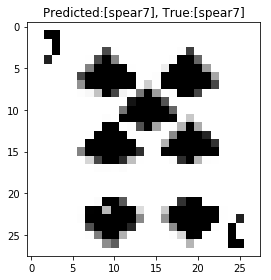

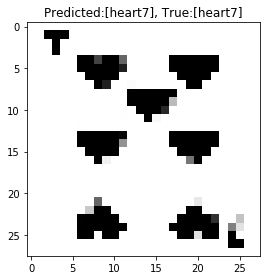

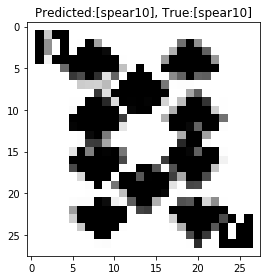

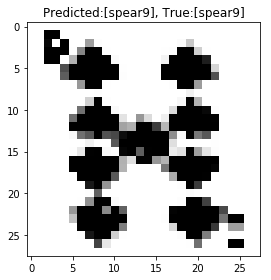

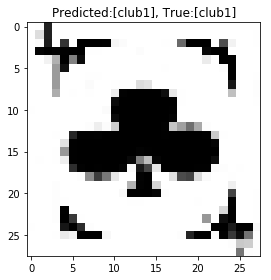

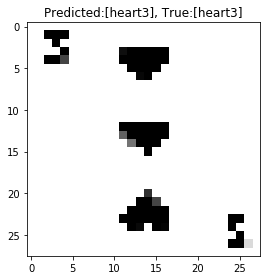

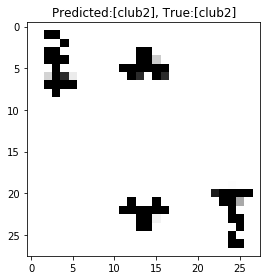

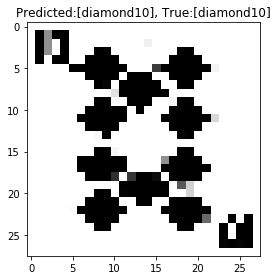

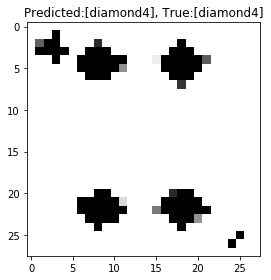

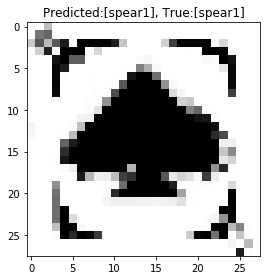

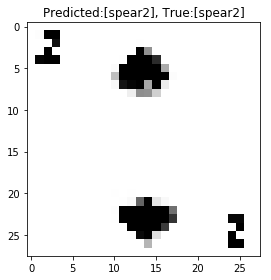

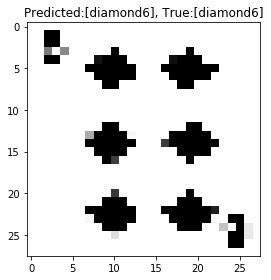

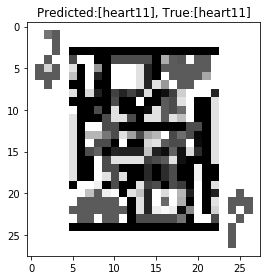

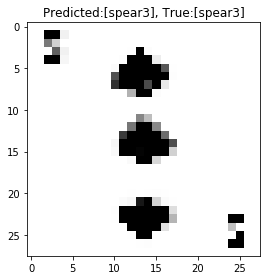

In [15]:
# 把每一張牌的圖像及預測結果打印出來
for i in range(X_test_randomize.shape[0]):
    true_class = idx_to_label.get(np.argmax(y_test_randomize[i]))
    predict_class = idx_to_label.get(prediction[i])
    plt.title("Predicted:[{}], True:[{}]".format(predict_class, true_class))
    plt.imshow(X_test_randomize[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.tight_layout()  
    plt.show()

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:
* 透過土炮自製的圖像來進行深度學習,不僅有趣同時學習起來更有效率
* 當圖像資料不多的時候, 圖像增強 (Data Augmentation)可以幫上忙